In [ ]:
!mkdir ~/.kaggle/

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d gti-upm/leapgestrecog

100% 2.12G/2.13G [00:16<00:00, 157MB/s]
100% 2.13G/2.13G [00:16<00:00, 141MB/s]


In [ ]:
! unzip leapgestrecog.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapges

In [ ]:
! pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.1 MB/s 


In [221]:
import cv2
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as tt
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from facenet_pytorch import MTCNN
from pathlib import Path
from tqdm import tqdm

In [222]:
ROOT_PATH = '/content/leapGestRecog'

In [223]:
def CreateDataset(root_path):
  print('Create dataframe...')
  df = []
  for sub in tqdm(os.listdir(root_path)):
    for label in os.listdir(root_path + '/' + sub):
      for image in os.listdir(root_path + '/' + sub + '/' + label):
        df.append(root_path + '/' + sub + '/' + label + '/' + image)
  return df

In [289]:
images = CreateDataset(ROOT_PATH)
images[:5]

Create dataframe...


100%|██████████| 10/10 [00:00<00:00, 426.74it/s]


['/content/leapGestRecog/05/06_index/frame_05_06_0020.png',
 '/content/leapGestRecog/05/06_index/frame_05_06_0116.png',
 '/content/leapGestRecog/05/06_index/frame_05_06_0127.png',
 '/content/leapGestRecog/05/06_index/frame_05_06_0077.png',
 '/content/leapGestRecog/05/06_index/frame_05_06_0098.png']

In [225]:
class SIGNSDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, labels, transform=None):      
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

In [226]:
transformer = tt.Compose([tt.Resize((48,48)),
                          tt.ToTensor()])        

In [228]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [227]:
labels = [int(os.path.basename(i).split('_')[2])-1 for i in images]

In [229]:
train_dataset = SIGNSDataset(x_train, y_train, transformer)
val_dataset = SIGNSDataset(x_val, y_val, transformer)

In [230]:
bs = 18

In [231]:
train_dl = DataLoader(train_dataset, bs, shuffle=True)
val_dl = DataLoader(val_dataset, bs)

In [232]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [233]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])


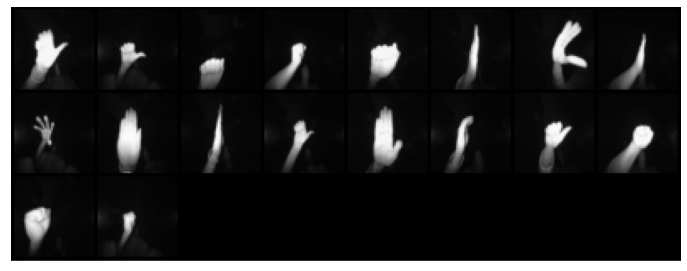

In [234]:
show_batch(train_dl)

In [235]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
#

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [302]:
model = ResNet(1, len(set(labels)))

In [237]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [238]:
num_epochs = 5
model.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            model.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_dl)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(val_dl):
            
                test_outputs = model(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        model.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/889]. Loss: 0.468. Acc: 0.056. Test acc: 0.142
Epoch [1/5]. Step [301/889]. Loss: 0.053. Acc: 0.703. Test acc: 0.908
Epoch [1/5]. Step [601/889]. Loss: 0.008. Acc: 0.956. Test acc: 0.976
Epoch [2/5]. Step [1/889]. Loss: 0.007. Acc: 0.944. Test acc: 0.995
Epoch [2/5]. Step [301/889]. Loss: 0.006. Acc: 0.969. Test acc: 0.917
Epoch [2/5]. Step [601/889]. Loss: 0.003. Acc: 0.983. Test acc: 0.980
Epoch [3/5]. Step [1/889]. Loss: 0.000. Acc: 1.000. Test acc: 0.999
Epoch [3/5]. Step [301/889]. Loss: 0.003. Acc: 0.983. Test acc: 0.996
Epoch [3/5]. Step [601/889]. Loss: 0.006. Acc: 0.975. Test acc: 1.000
Epoch [4/5]. Step [1/889]. Loss: 0.000. Acc: 1.000. Test acc: 1.000
Epoch [4/5]. Step [301/889]. Loss: 0.002. Acc: 0.990. Test acc: 0.984
Epoch [4/5]. Step [601/889]. Loss: 0.006. Acc: 0.977. Test acc: 0.968
Epoch [5/5]. Step [1/889]. Loss: 0.000. Acc: 1.000. Test acc: 0.999
Epoch [5/5]. Step [301/889]. Loss: 0.005. Acc: 0.986. Test acc: 1.000
Epoch [5/5]. Step [601/889]. L

In [240]:
torch.save(model, './gestures_model.pth')

In [241]:
net = torch.load('./gestures_model.pth')

In [242]:
print(net)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=

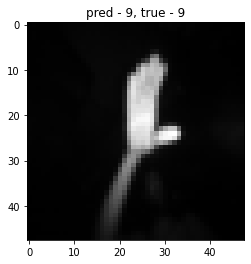

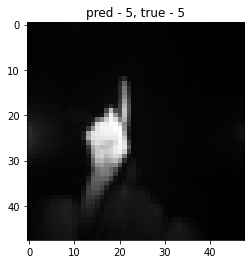

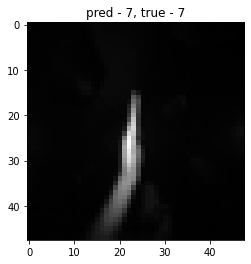

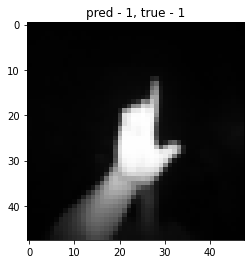

In [244]:
with torch.no_grad():
    for i, data in enumerate(val_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = net(images)
        plt.title(f'pred - {outputs[0].argmax()}, true - {labels[0]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>5:
            break

In [247]:
!wget 'https://phonoteka.org/uploads/posts/2021-05/1620322801_51-phonoteka_org-p-emotsionalnii-fon-vidi-54.jpg' -O test.png

--2022-09-22 11:41:02--  https://phonoteka.org/uploads/posts/2021-05/1620322801_51-phonoteka_org-p-emotsionalnii-fon-vidi-54.jpg
Resolving phonoteka.org (phonoteka.org)... 151.80.243.31
Connecting to phonoteka.org (phonoteka.org)|151.80.243.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245053 (239K) [image/jpeg]
Saving to: ‘test.png’

test.png            100%[===================>] 239.31K   686KB/s    in 0.3s    

2022-09-22 11:41:03 (686 KB/s) - ‘test.png’ saved [245053/245053]



In [ ]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

    
class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.emodel = torch.load('./gestures_model.pth')
        self.emodel.eval()

    def _draw(self, frame, boxes, probs, landmarks, emotions):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for box, prob, ld, emotion in zip(boxes, probs, landmarks, emotions):
                # Draw rectangle on frame
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # Show probability
                cv2.putText(frame, 
                    emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Draw landmarks
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            pass

        return frame
    
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
      if digit == 0:
        return 'palm'
      elif digit == 1:
        return 'l'
      elif digit == 2:
        return 'fist'
      elif digit == 3:
        return 'fist_moved'
      elif digit == 4:
        return 'thumb'
      elif digit == 5:
        return 'index'
      elif digit == 6:
        return 'ok'
      elif digit == 7:
        return 'palm_moved'
      elif digit == 8:
        return 'c'
      elif digit == 9:
        return 'down'
       
    def run(self, path_to_img):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                
        frame = cv2.imread(path_to_img)
        
        # detect face box, probability and landmarks
        boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
        print(boxes)

        faces = self.crop_faces(frame, boxes)
        gestures = []
        for face in faces:
            face = cv2.resize(face,(48,48))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
            gesture = self.emodel(torch_face[None, ...])
            gesture = self.digit_to_classname(gesture.argmax())
            gestures.append(gesture)

        # draw on frame
        self._draw(frame, boxes, probs, landmarks, gestures)
    
        # Show the frame
        cv2.imwrite('Face_Detection.png', frame)
        plt.figure(figsize=(20, 10))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.show()
        
        
# Run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)